## Principal Component Analysis. Part II: Looking for sutile weird spectra 

In [12]:
%matplotlib inline
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import pandas as pd
import time
from matplotlib.pyplot import figure
import math as mt

from scipy import integrate
import sys
import warnings
time0 = time.perf_counter()

#### Navigating the cube
As shown in other codes, we navigate the MIRI cube and make the changes we think are needed for this analysis

In [13]:
spec_dir = 'data_products/'
channel = '2'  # 1 // 2 // 3 // 4 // all
band = 'short' # shor // medi // long // all
filesave = 'data/'
low = 1250
up= 1325
scale = 1e6*1e-26/((3.335641e-11)*1e4) # Changing to W/cm2 sr cm-1
scale = scale*1.1 # because of the oversized PSF of MIRIsim (REMOVE WITH REAL DATA)
filedf = 'mergedspectra.txt'

filename= 'jupiter_ch4.res'
df = pd.read_csv(filename, sep='\s+', header = None)
df[0] = 10**4/df[0]
wavex = df[0]
spex = df[2]

if channel=='all':
    filename = spec_dir + 'allcube_ch1-2-3-4-mediumshortlong-_s3d.fits'
else:
    filename = spec_dir + 'Level3_ch' + str(channel) + '-' + str(band) + '_s3d.fits'
    
hdu = fits.open(filename)
hdr = hdu['SCI'].header
data = hdu['SCI'].data
RA = hdu['SCI'].header['RA_V1']
DEC = hdu['SCI'].header['DEC_V1']
CRPIX1 = hdu['SCI'].header['CRPIX1']
CRPIX2 = hdu['SCI'].header['CRPIX2']

ny = data.shape[1]
nx = data.shape[2]

if channel=='all':
    wave = hdu['WCS-TABLE'].data['wavelength'][0] #IF WORKING WITH 4 CHANNEL CUBE
else:    
    wave = np.arange(hdr['NAXIS3'])*hdr['CDELT3']+hdr['CRVAL3'] #IF WORKING WITH 1 CHANNEL or SUBBAND CUBE
    
wave = wave + 0.0033
wave = np.array(wave)
lenwave = int(len(wave))

wavenumber = 10**4/wave
for ix in range(len(wavenumber)):
            if wavenumber[ix] < low:
                lower = ix
                break
for iix in range(len(wavenumber)):
            if wavenumber[iix] < up:
                upper = iix
                break

#### Creating the dataframe for all the spectra

We add the spectra in  the dataframe if there is data on that spaxel. We also purge all the spectra, since some of them (around 7% of the spaxels in my simulation of MIRIsim) are corrupted.

We later save the df as a txt file in case we want to use it separately in other code.


In [14]:
warnings.filterwarnings("ignore")
df = pd.DataFrame(wave)
m = 1
for i in range(ny):
    for ii in range(nx):
        if sum(data[:,i,ii]*scale) !=0 :
            df[m] = data[:,i,ii]*scale
            m = m + 1

for i in range(df.shape[1]):
    count = (df[i] == 0).sum()
    count = int(count)
    if count > 10:
        df = df.drop(columns=[i])
        
df.to_csv(filedf, header=None, 
          index=None, sep=' ')
df = pd.read_csv(filedf, header=None, sep='\s+')
df

,0,1,2,3,4,5,6,7,8,9,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,7.4943,4.358876e-09,3.993168e-09,3.902826e-09,3.868369e-09,4.237903e-09,3.619014e-09,3.598226e-09,3.646688e-09,3.676094e-09,...,7.664641e-09,7.808638e-09,9.860915e-09,1.105829e-08,1.111258e-08,1.111711e-08,7.763668e-09,1.017214e-08,1.110616e-08,1.110766e-08
1,7.4963,4.206282e-09,4.129420e-09,4.074037e-09,4.049780e-09,4.076491e-09,3.734902e-09,3.757347e-09,3.855070e-09,3.904258e-09,...,8.426938e-09,8.716063e-09,1.089157e-08,1.198101e-08,1.216314e-08,1.255386e-08,8.581836e-09,1.153258e-08,1.201901e-08,1.221223e-08
2,7.4983,4.088199e-09,4.067737e-09,4.084302e-09,4.123733e-09,4.141640e-09,3.998715e-09,3.922364e-09,4.009246e-09,4.068820e-09,...,8.474404e-09,8.918687e-09,1.120068e-08,1.257546e-08,1.352094e-08,1.391402e-08,8.733367e-09,1.191185e-08,1.269344e-08,1.367712e-08
3,7.5003,6.700290e-09,6.735681e-09,6.682536e-09,6.683286e-09,6.650305e-09,6.979646e-09,6.644232e-09,6.800452e-09,6.937234e-09,...,1.354635e-08,1.399600e-08,1.698194e-08,1.900426e-08,2.013577e-08,1.999312e-08,1.355628e-08,1.762145e-08,1.924839e-08,2.023012e-08
4,7.5023,1.365293e-08,1.390826e-08,1.385813e-08,1.377121e-08,1.387640e-08,1.423743e-08,1.371235e-08,1.411566e-08,1.427419e-08,...,2.501046e-08,2.560298e-08,2.978353e-08,3.282146e-08,3.403472e-08,3.354270e-08,2.479703e-08,3.033221e-08,3.306639e-08,3.406674e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,8.7463,1.274666e-08,1.280559e-08,1.282974e-08,1.287864e-08,1.288782e-08,1.205409e-08,1.230609e-08,1.212834e-08,1.206632e-08,...,2.181489e-08,2.284391e-08,2.744065e-08,2.947488e-08,2.988988e-08,3.050899e-08,2.268712e-08,2.844162e-08,2.952937e-08,2.996727e-08
627,8.7483,1.770218e-08,1.762114e-08,1.750253e-08,1.752163e-08,1.752884e-08,1.638527e-08,1.668163e-08,1.675326e-08,1.681119e-08,...,2.942849e-08,3.040718e-08,3.619066e-08,3.919050e-08,3.942106e-08,3.985833e-08,3.028339e-08,3.712027e-08,3.923742e-08,3.946996e-08
628,8.7503,1.937691e-08,1.933953e-08,1.927146e-08,1.924578e-08,1.924465e-08,1.808328e-08,1.826079e-08,1.852236e-08,1.861702e-08,...,3.143224e-08,3.249439e-08,3.821780e-08,4.162073e-08,4.133258e-08,4.111889e-08,3.272027e-08,3.924251e-08,4.164574e-08,4.128942e-08
629,8.7523,1.731043e-08,1.733158e-08,1.729871e-08,1.728994e-08,1.730942e-08,1.635615e-08,1.713519e-08,1.731175e-08,1.745164e-08,...,2.811639e-08,2.934544e-08,3.420425e-08,3.755348e-08,3.719970e-08,3.689384e-08,3.002199e-08,3.516736e-08,3.759834e-08,3.714105e-08


#### We reduce the spectra

to three different waevlengths, one emission line of the branches P and Q, and the emission line of the Q branch. Also is important to fix the values around zero for the later 3D representation, for that we already calculate the mean value of every column in the dataframe.

In [15]:
dfPCA = df.iloc[[20,82,150],:] # for 7.66,7.53 and 7.79 microns

a = np.linspace(dfPCA.iloc[0,0],dfPCA.iloc[0,0],dfPCA.shape[1]-1)
b = np.linspace(dfPCA.iloc[1,0],dfPCA.iloc[1,0],dfPCA.shape[1]-1)
c = np.linspace(dfPCA.iloc[2,0],dfPCA.iloc[2,0],dfPCA.shape[1]-1)

az = dfPCA.iloc[0,1:]
bz = dfPCA.iloc[1,1:]
cz = dfPCA.iloc[2,1:]

meanaz = np.mean(az)
meanbz = np.mean(bz)
meancz = np.mean(cz)

#### We plot all the spectra

And check if there is some of them that look weird, specially in the emission lines we want to study.

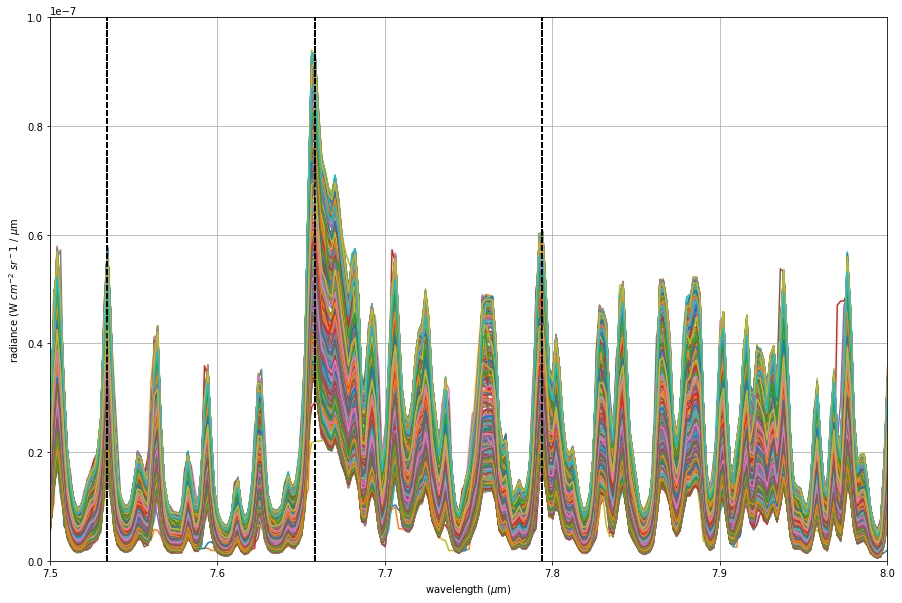

In [16]:
ax = plt.gca()
for i in range(df.shape[1]-1):
        df.plot(x=0, y=i+1, ax=ax, figsize=(15,10),legend=False)
        plt.axvline(7.6583, linestyle = '--', color='black')
        plt.axvline(7.534, linestyle = '--', color='black')
        plt.axvline(7.794, linestyle = '--', color='black')
        ax.set_xlim(7.5,8)
        ax.set_ylim(0,1e-7)
        ax.set_xlabel('wavelength ($\mu$m)')
        ax.set_ylabel('radiance (W $cm^{-2}$ $sr^-1$ / $\mu$m')
        ax.grid()

#### We plot all the spectra (only the 3 wavelengths)

And check if there is some of them that look weird.

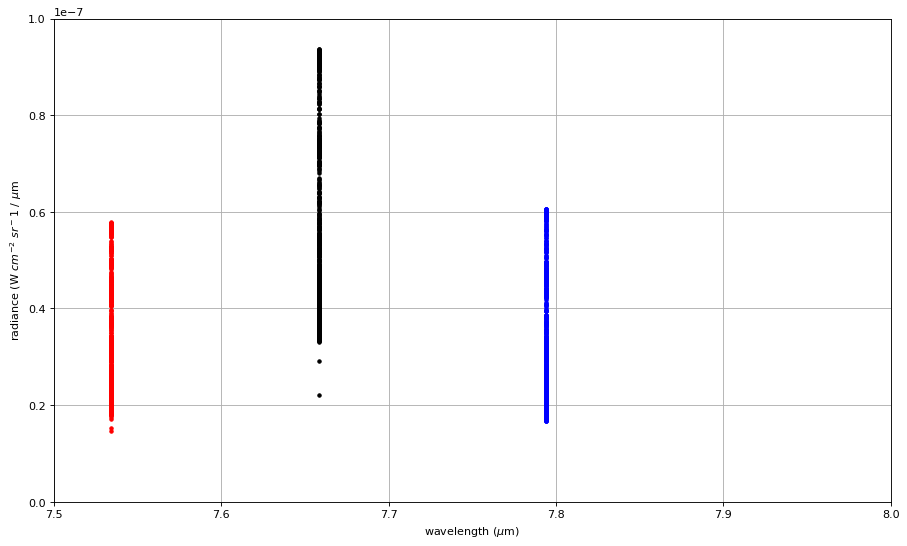

In [17]:
figure(figsize=(13.5, 8), dpi=80)
ax = plt.gca()

plt.plot(a,az, '.',color='red')
plt.plot(b,bz, '.',color='black')
plt.plot(c,cz, '.',color='blue')
ax.set_xlim(7.5,8)
ax.set_ylim(0,1e-7)
ax.set_xlabel('wavelength ($\mu$m)')
ax.set_ylabel('radiance (W $cm^{-2}$ $sr^-1$ / $\mu$m')
ax.grid()

Calculate the new array but around zero by subtracting the mean

In [18]:
az = az - meanaz 
bz = bz - meanbz
cz = cz - meancz 
dfPCA = pd.DataFrame()
dfPCA[0]=az
dfPCA[1]=bz
dfPCA[2]=cz

We plot the values and calculate the 3d line by linear regression.

<IPython.core.display.Javascript object>


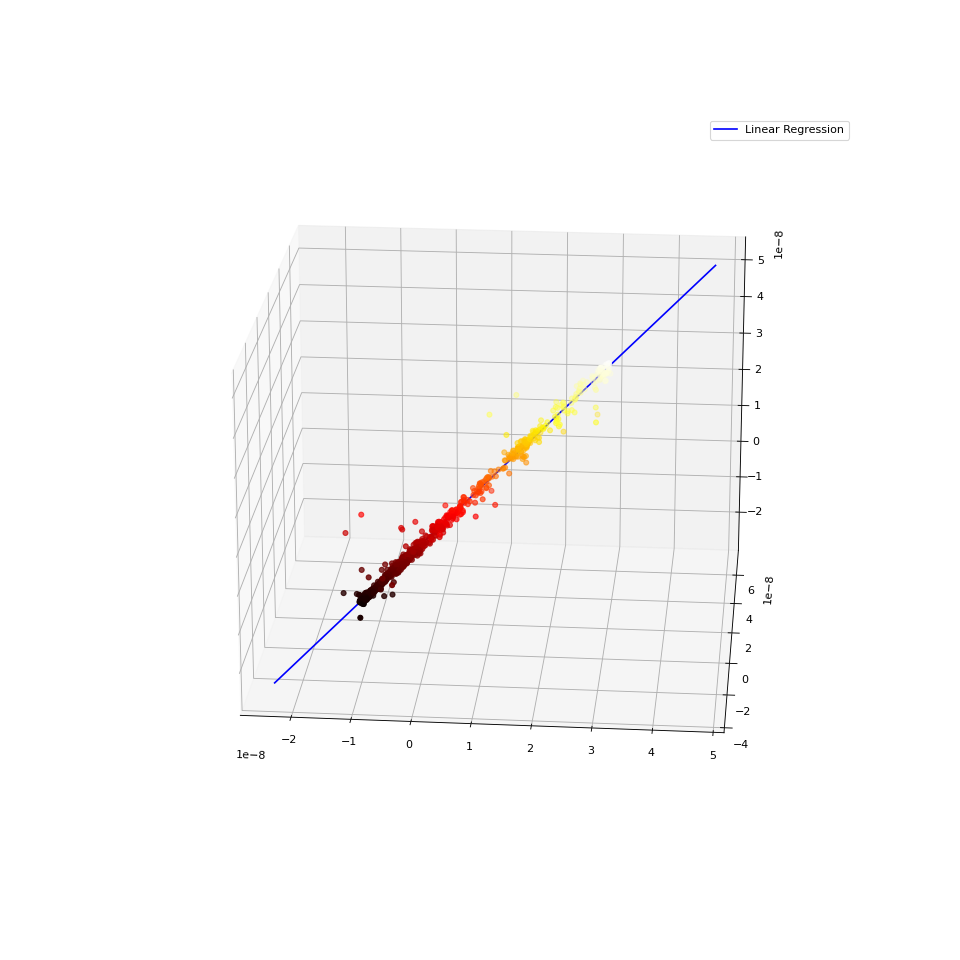

Runtime of the extraction: 61.3 seconds


In [19]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D

figure(figsize=(12, 12), dpi=80)
ax = plt.axes(projection='3d')
ax.scatter3D(az,bz,cz, c=cz, cmap='hot')

data = pd.DataFrame(columns=['x', 'y', 'z'])
data['x'] = az
data['y'] = bz
data['z'] = cz

X = data[['x', 'y', 'z']].values
Xlen = X.shape[0]
avgPointCloud = 1 / Xlen * np.array([np.sum(X[0, :]), np.sum(X[1, :]), np.sum(X[2, :])])
Xmean = X - avgPointCloud

cov = 1 / Xlen * X.T.dot(Xmean) # slope

t = np.linspace(-2e8,4e8,1200)
linearReg = avgPointCloud + cov[:, 0] * np.vstack(t)

ax.plot(linearReg[:, 0], linearReg[:, 1], linearReg[:, 2], 'blue', label='Linear Regression')
ax.legend()

plt.show()


time1 = time.perf_counter()
print(f"Runtime of the extraction: {time1 - time0:0.1f} seconds")